In [1]:
# Step 1: Environment Setup
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.model_selection import train_test_split
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
import matplotlib.pyplot as plt
import numpy as np
import os

In [2]:
# Step 2: Dataset Loading and Preprocessing
def load_and_preprocess_dataset():
    # Using CIFAR-10 as an example FPS-related dataset
    (x_train, y_train), (x_test, y_test) = tf.keras.datasets.cifar10.load_data()

    # Normalize pixel values to range [0, 1]
    x_train, x_test = x_train / 255.0, x_test / 255.0

    # Split into training, validation, and test sets
    x_train, x_val, y_train, y_val = train_test_split(x_train, y_train, test_size=0.15, random_state=42)

    # Data augmentation
    datagen = ImageDataGenerator(
        rotation_range=15,
        width_shift_range=0.1,
        height_shift_range=0.1,
        horizontal_flip=True,
        zoom_range=0.1
    )
    datagen.fit(x_train)

    return x_train, x_val, x_test, y_train, y_val, y_test, datagen

In [3]:
# Step 3: Model Definition
def build_cnn_model(input_shape=(32, 32, 3), num_classes=10):
    model = Sequential([
        Conv2D(32, (3, 3), activation='relu', input_shape=input_shape),
        MaxPooling2D((2, 2)),
        BatchNormalization(),
        Dropout(0.25),

        Conv2D(64, (3, 3), activation='relu'),
        MaxPooling2D((2, 2)),
        BatchNormalization(),
        Dropout(0.25),

        Conv2D(128, (3, 3), activation='relu'),
        MaxPooling2D((2, 2)),
        BatchNormalization(),
        Dropout(0.25),

        Flatten(),
        Dense(128, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(0.01)),
        Dropout(0.5),
        Dense(num_classes, activation='softmax')
    ])
    return model

# Step 3b: Transfer Learning (Optional)
def build_transfer_learning_model(input_shape=(32, 32, 3), num_classes=10):
    base_model = MobileNetV2(weights='imagenet', include_top=False, input_shape=input_shape)
    base_model.trainable = False  # Freeze base layers

    model = Sequential([
        base_model,
        tf.keras.layers.GlobalAveragePooling2D(),
        Dense(128, activation='relu'),
        Dropout(0.5),
        Dense(num_classes, activation='softmax')
    ])
    return model

In [4]:
# Step 4: Training and Validation
def train_model(model, datagen, x_train, y_train, x_val, y_val, batch_size=32, epochs=20):
    # Compile the model
    model.compile(optimizer=Adam(learning_rate=0.001),
                  loss='sparse_categorical_crossentropy',
                  metrics=['accuracy'])

    # Early stopping
    early_stopping = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)

    # Train the model
    history = model.fit(
        datagen.flow(x_train, y_train, batch_size=batch_size),
        validation_data=(x_val, y_val),
        epochs=epochs,
        callbacks=[early_stopping]
    )
    return model, history

In [5]:
# Step 5: Hyperparameter Tuning (Optional)
def hyperparameter_tuning(datagen, x_train, y_train, x_val, y_val):
    best_model = None
    best_accuracy = 0
    params = [
        {'batch_size': 32, 'learning_rate': 0.001},
        {'batch_size': 64, 'learning_rate': 0.0001},
    ]

    for param in params:
        model = build_cnn_model()
        model.compile(optimizer=Adam(learning_rate=param['learning_rate']),
                      loss='sparse_categorical_crossentropy',
                      metrics=['accuracy'])

        history = model.fit(
            datagen.flow(x_train, y_train, batch_size=param['batch_size']),
            validation_data=(x_val, y_val),
            epochs=5,  # Keep epochs low for quick tuning
            verbose=0
        )
        val_accuracy = max(history.history['val_accuracy'])
        if val_accuracy > best_accuracy:
            best_accuracy = val_accuracy
            best_model = model

    print(f"Best validation accuracy: {best_accuracy}")
    return best_model

In [6]:
# Step 6: Evaluation and Visualization
def evaluate_model(model, x_test, y_test):
    test_loss, test_accuracy = model.evaluate(x_test, y_test)
    print(f"Test Accuracy: {test_accuracy}")
    return test_loss, test_accuracy

def plot_history(history):
    plt.figure(figsize=(12, 5))

    # Plot accuracy
    plt.subplot(1, 2, 1)
    plt.plot(history.history['accuracy'], label='Train Accuracy')
    plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
    plt.legend()
    plt.title('Accuracy')

    # Plot loss
    plt.subplot(1, 2, 2)
    plt.plot(history.history['loss'], label='Train Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.legend()
    plt.title('Loss')

    plt.show()

170498071/170498071 ━━━━━━━━━━━━━━━━━━━━ 4s 0us/step


/usr/local/lib/python3.10/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/20


/usr/local/lib/python3.10/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


1329/1329 ━━━━━━━━━━━━━━━━━━━━ 47s 28ms/step - accuracy: 0.2823 - loss: 3.3913 - val_accuracy: 0.2956 - val_loss: 2.5262
Epoch 2/20
1329/1329 ━━━━━━━━━━━━━━━━━━━━ 70s 24ms/step - accuracy: 0.4525 - loss: 1.6928 - val_accuracy: 0.4767 - val_loss: 1.6955
Epoch 3/20
1329/1329 ━━━━━━━━━━━━━━━━━━━━ 31s 23ms/step - accuracy: 0.4999 - loss: 1.5641 - val_accuracy: 0.5047 - val_loss: 1.5426
Epoch 4/20
1329/1329 ━━━━━━━━━━━━━━━━━━━━ 42s 24ms/step - accuracy: 0.5283 - loss: 1.5058 - val_accuracy: 0.5867 - val_loss: 1.3540
Epoch 5/20
1329/1329 ━━━━━━━━━━━━━━━━━━━━ 42s 24ms/step - accuracy: 0.5505 - loss: 1.4639 - val_accuracy: 0.5440 - val_loss: 1.4798
Epoch 6/20
1329/1329 ━━━━━━━━━━━━━━━━━━━━ 31s 23ms/step - accuracy: 0.5591 - loss: 1.4393 - val_accuracy: 0.6047 - val_loss: 1.3067
Epoch 7/20
1329/1329 ━━━━━━━━━━━━━━━━━━━━ 32s 24ms/step - accuracy: 0.5688 - loss: 1.4184 - val_accuracy: 0.6425 - val_loss: 1.1858
Epoch 8/20
1329/1329 ━━━━━━━━━━━━━━━━━━━━ 31s 23ms/step - accuracy: 0.5817 - loss: 1.39

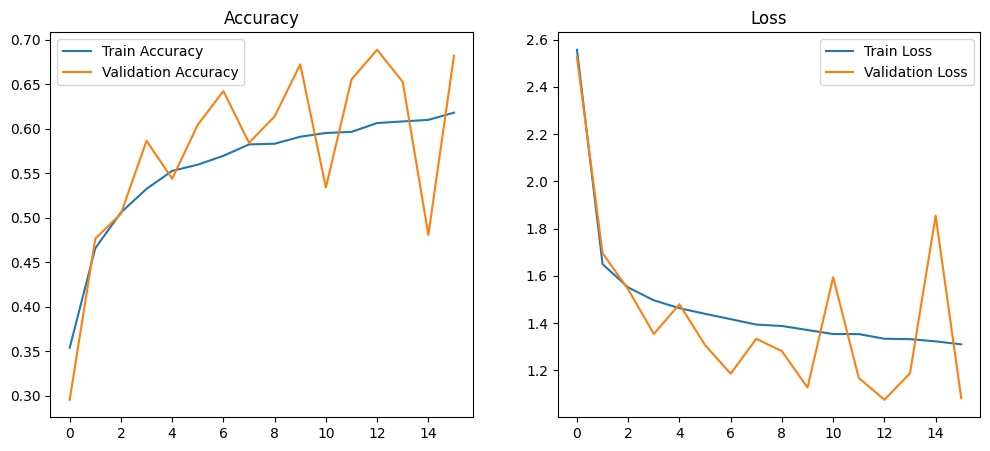

In [7]:
# Step 7: Main Pipeline
def main():
    x_train, x_val, x_test, y_train, y_val, y_test, datagen = load_and_preprocess_dataset()

    # Build model
    model = build_cnn_model()  # Change to build_transfer_learning_model() for transfer learning

    # Train model
    model, history = train_model(model, datagen, x_train, y_train, x_val, y_val)

    # Evaluate model
    evaluate_model(model, x_test, y_test)

    # Plot results
    plot_history(history)

# Run the pipeline
main()

/usr/local/lib/python3.10/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/10


/usr/local/lib/python3.10/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


781/781 ━━━━━━━━━━━━━━━━━━━━ 40s 48ms/step - accuracy: 0.2547 - loss: 1.9903 - val_accuracy: 0.4709 - val_loss: 1.4598
Epoch 2/10
  1/781 ━━━━━━━━━━━━━━━━━━━━ 5s 7ms/step - accuracy: 0.3438 - loss: 1.7257

/usr/lib/python3.10/contextlib.py:153: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(typ, value, traceback)


781/781 ━━━━━━━━━━━━━━━━━━━━ 1s 834us/step - accuracy: 0.3438 - loss: 1.7257 - val_accuracy: 0.4556 - val_loss: 1.5280
Epoch 3/10
781/781 ━━━━━━━━━━━━━━━━━━━━ 36s 44ms/step - accuracy: 0.4164 - loss: 1.6084 - val_accuracy: 0.5100 - val_loss: 1.3308
Epoch 4/10
781/781 ━━━━━━━━━━━━━━━━━━━━ 1s 827us/step - accuracy: 0.3438 - loss: 1.4839 - val_accuracy: 0.5215 - val_loss: 1.3063
Epoch 5/10
781/781 ━━━━━━━━━━━━━━━━━━━━ 41s 45ms/step - accuracy: 0.4706 - loss: 1.4759 - val_accuracy: 0.5777 - val_loss: 1.1835
Epoch 6/10
781/781 ━━━━━━━━━━━━━━━━━━━━ 1s 679us/step - accuracy: 0.5000 - loss: 1.3855 - val_accuracy: 0.5796 - val_loss: 1.1850
Epoch 7/10
781/781 ━━━━━━━━━━━━━━━━━━━━ 35s 44ms/step - accuracy: 0.5077 - loss: 1.3776 - val_accuracy: 0.5415 - val_loss: 1.2731
Epoch 8/10
781/781 ━━━━━━━━━━━━━━━━━━━━ 1s 846us/step - accuracy: 0.4219 - loss: 1.2883 - val_accuracy: 0.5455 - val_loss: 1.2744
Epoch 9/10
781/781 ━━━━━━━━━━━━━━━━━━━━ 34s 43ms/step - accuracy: 0.5228 - loss: 1.3290 - val_accurac

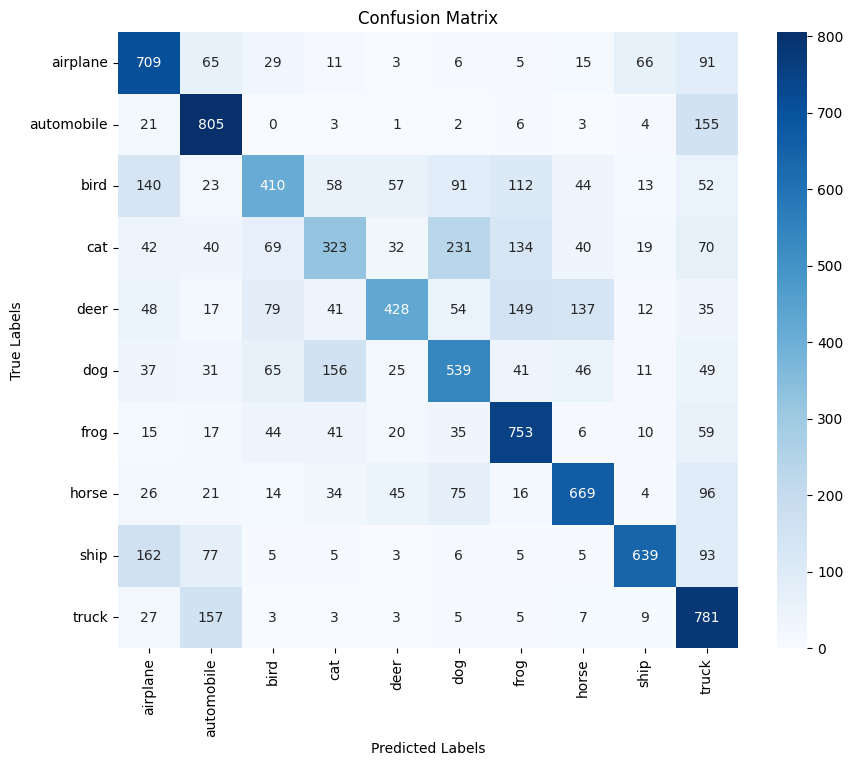

In [10]:
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras import layers, models
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.model_selection import train_test_split

# Step 1: Dataset Preparation and Preprocessing
(X_train, y_train), (X_test, y_test) = tf.keras.datasets.cifar10.load_data()

# Normalize pixel values to be between 0 and 1
X_train, X_test = X_train / 255.0, X_test / 255.0

# Convert labels to one-hot encoding
y_train = tf.keras.utils.to_categorical(y_train, 10)
y_test = tf.keras.utils.to_categorical(y_test, 10)

# Data Augmentation
datagen = ImageDataGenerator(
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)

datagen.fit(X_train)

# Step 2: Model Development
def build_cnn_model():
    model = models.Sequential([
        layers.Conv2D(32, (3, 3), activation='relu', input_shape=(32, 32, 3)),
        layers.MaxPooling2D((2, 2)),
        layers.Conv2D(64, (3, 3), activation='relu'),
        layers.MaxPooling2D((2, 2)),
        layers.Conv2D(64, (3, 3), activation='relu'),
        layers.Flatten(),
        layers.Dense(64, activation='relu'),
        layers.Dense(10, activation='softmax')
    ])
    model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
    return model

# Step 3: Train the Model
model = build_cnn_model()

# Training the model with data augmentation
history = model.fit(datagen.flow(X_train, y_train, batch_size=64),
                    epochs=10,
                    validation_data=(X_test, y_test),
                    steps_per_epoch=len(X_train) // 64)

# Step 8: Evaluation - Precision, Recall, F1-Score, and Confusion Matrix
def evaluate_model(model, X_test, y_test, class_names):
    """
    Evaluate the model using precision, recall, F1-score, and confusion matrix.

    Args:
        model: Trained Keras model.
        X_test: Test dataset features.
        y_test: True labels for the test dataset.
        class_names: List of class names for the dataset.

    Returns:
        Prints classification report and displays confusion matrix.
    """
    # Predict class probabilities and get the predicted class labels
    y_pred_probs = model.predict(X_test)
    y_pred = y_pred_probs.argmax(axis=1)
    y_true = y_test.argmax(axis=1)

    # Classification report
    print("Classification Report:")
    print(classification_report(y_true, y_pred, target_names=class_names))

    # Confusion matrix
    cm = confusion_matrix(y_true, y_pred)

    # Plot confusion matrix
    plt.figure(figsize=(10, 8))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
    plt.xlabel('Predicted Labels')
    plt.ylabel('True Labels')
    plt.title('Confusion Matrix')
    plt.show()

# CIFAR-10 class names
class_names = ['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']

# Call evaluate_model function
evaluate_model(model, X_test, y_test, class_names)
